# Mode Comparison Grid: Layer × Intervention Type Analysis

This notebook visualizes **real** intervention effects computed from Phase B results in `vm_results/results`.

Data flow:

1. `scripts/generate_mock_vm_results.py --root vm_results/results` generates experimental results for Add/Lesion/Rescue.
2. `05_mode_comparison_stats.ipynb` loads those runs and writes:
   - `evaluation/outputs/mode_comparison/mode_comparison_stats.csv`
3. This notebook loads that CSV and visualizes:
   - **Rows**: Layers (25, 26, 27)
   - **Columns**: Modes (Add, Lesion, Rescue)
   - **Cell content**: Δ accuracy as a function of parameter (α, γ, β ∈ {0.5, 1.0, 2.0})
   - **P-values**: McNemar's test for paired binary outcomes (bold if significant)
   - For both localities: COT and Answer.


In [1]:
import sys
sys.path.insert(0, '../..')

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Output directory for figures
OUTPUT_DIR = Path('../outputs/mode_comparison')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set up clean plotting style
plt.rcParams.update({
    'figure.figsize': (14, 10),
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

print('Setup complete!')

Setup complete!


## 2. Load aggregated stats from vm_results/results

We use `mode_comparison_stats.csv` produced by `05_mode_comparison_stats.ipynb`, which in turn reads Phase B runs from `vm_results/results/data__{locality}_locality_*`.

Expected columns in the CSV:

- `mode` ∈ {`add`, `lesion`, `rescue`}
- `layer` ∈ {25, 26, 27}
- `param_value` ∈ {0.5, 1.0, 2.0} (α/γ/β depending on mode)
- `param_type` ∈ {`alpha`, `gamma`, `beta`}
- `locality` ∈ {`cot`, `answer`}
- `delta_mean` = mean Δ accuracy (intv − baseline)
- `mcnemar_p` = McNemar's test p-value (for paired binary outcomes)


In [2]:
STATS_PATH = Path('../outputs/mode_comparison/mode_comparison_stats.csv')
if not STATS_PATH.exists():
    raise FileNotFoundError(f"Stats file not found: {STATS_PATH}. Run 05_mode_comparison_stats.ipynb first.")

stats = pd.read_csv(STATS_PATH)
print(f"Loaded stats: {len(stats)} rows from {STATS_PATH}")

# Keep only the modes we visualize in this grid
stats = stats[stats['mode'].isin(['add', 'lesion', 'rescue'])].copy()

# Rename columns to match the plotting code expectations
stats = stats.rename(columns={'param_value': 'param', 'delta_mean': 'delta'})
stats['param'] = stats['param'].astype(float)

# Ensure mcnemar_p column exists (default to NaN if missing)
if 'mcnemar_p' not in stats.columns:
    print("Warning: mcnemar_p column not found. Re-run 05_mode_comparison_stats.ipynb to generate p-values.")
    stats['mcnemar_p'] = np.nan

layers = sorted(stats['layer'].unique())
params = sorted(stats['param'].unique())
localities = sorted(stats['locality'].unique())

print("Layers:", layers)
print("Params:", params)
print("Localities:", localities)

# Build separate DataFrames for COT and Answer localities with the columns used by the plotting function
cols = ['mode', 'layer', 'param', 'delta', 'locality', 'mcnemar_p']
cot_data = stats[stats['locality'] == 'cot'][cols].copy()
answer_data = stats[stats['locality'] == 'answer'][cols].copy()

print("\nCOT Locality Data (from vm_results/results):")
print(cot_data.pivot_table(index=['layer', 'param'], columns='mode', values='delta'))

print("\nAnswer Locality Data (from vm_results/results):")
print(answer_data.pivot_table(index=['layer', 'param'], columns='mode', values='delta'))

print("\nP-values (McNemar's test) - COT Locality:")
print(cot_data.pivot_table(index=['layer', 'param'], columns='mode', values='mcnemar_p'))

Loaded stats: 54 rows from ../outputs/mode_comparison/mode_comparison_stats.csv
Layers: [np.int64(25), np.int64(26), np.int64(27)]
Params: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]
Localities: ['answer', 'cot']

COT Locality Data (from vm_results/results):
mode          add  lesion  rescue
layer param                      
25    0.5    0.12   -0.16    0.08
      1.0    0.20   -0.28    0.20
      2.0    0.28   -0.24    0.32
26    0.5    0.00    0.04   -0.04
      1.0    0.04    0.04    0.00
      2.0   -0.08   -0.04   -0.08
27    0.5   -0.08    0.00    0.04
      1.0    0.00    0.04   -0.04
      2.0    0.04   -0.04   -0.04

Answer Locality Data (from vm_results/results):
mode          add  lesion  rescue
layer param                      
25    0.5    0.04   -0.20    0.12
      1.0    0.20   -0.20    0.12
      2.0    0.16   -0.36    0.20
26    0.5    0.00   -0.04    0.04
      1.0   -0.04   -0.08   -0.08
      2.0    0.00   -0.04    0.04
27    0.5    0.00    0.04    0.00
    

## 3. Plotting function (Mode × Layer grid)

We reuse the original mini-heatmap grid, but the data now comes from `mode_comparison_stats.csv` instead of inline data generation.

**New features:**
- Each cell shows Δ value with significance stars (`*` p<0.05, `**` p<0.01, `***` p<0.001)
- P-values displayed below each Δ value
- Significant results are shown in **bold**
- McNemar's test is used (appropriate for paired binary outcomes)

In [7]:
def format_pvalue(p: float) -> str:
    """Format p-value for display."""
    if pd.isna(p):
        return 'p=N/A'
    elif p < 0.001:
        return 'p<.001'
    elif p < 0.01:
        return f'p={p:.3f}'
    else:
        return f'p={p:.2f}'


def get_significance_stars(p: float) -> str:
    """Return significance stars based on p-value."""
    if pd.isna(p):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''


def plot_mode_comparison_grid(data: pd.DataFrame,
                               locality: str,
                               title: str = None,
                               save_path: Path | None = None,
                               figsize: tuple = (14, 9)) -> plt.Figure:
    """Create a 3x3 grid of mini-heatmaps showing intervention effects with p-values.

    Delta Accuracy = Intervention Accuracy − Baseline Accuracy
    P-values from McNemar's test (paired binary outcomes)

    Args:
        data: DataFrame with columns [mode, layer, param, delta, locality, mcnemar_p]
        locality: 'cot' or 'answer' (for labeling)
        title: Optional figure title
        save_path: Optional path to save figure
        figsize: Figure size

    Returns:
        matplotlib Figure object
    """
    # Configuration
    layers_cfg = [25, 26, 27]
    modes = ['add', 'lesion', 'rescue']
    mode_labels = {'add': 'Add', 'lesion': 'Lesion', 'rescue': 'Rescue'}
    params_cfg = [0.5, 1.0, 2.0]

    # Filter to this locality
    data_loc = data[data['locality'] == locality]
    if data_loc.empty:
        raise ValueError(f"No data for locality={locality}")

    # Find global min/max for consistent color scale
    vmin = data_loc['delta'].min()
    vmax = data_loc['delta'].max()
    abs_max = max(abs(vmin), abs(vmax))

    fig = plt.figure(figsize=figsize)

    # Create main grid for heatmaps + colorbar
    gs = gridspec.GridSpec(len(layers_cfg), len(modes) + 1,
                           width_ratios=[1] * len(modes) + [0.08],
                           wspace=0.08, hspace=0.20)

    # Custom colormap (red for negative, green for positive)
    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    # Create each cell
    for row_idx, layer in enumerate(layers_cfg):
        for col_idx, mode in enumerate(modes):
            ax = fig.add_subplot(gs[row_idx, col_idx])

            # Get data for this layer/mode
            cell_data = data_loc[(data_loc['layer'] == layer) & (data_loc['mode'] == mode)]

            # Create 1D heatmap (params as x-axis)
            values = []
            pvalues = []
            for p in params_cfg:
                row = cell_data[cell_data['param'] == p]
                if len(row) > 0:
                    values.append(row['delta'].values[0])
                    pvalues.append(row['mcnemar_p'].values[0] if 'mcnemar_p' in row.columns else np.nan)
                else:
                    values.append(0.0)
                    pvalues.append(np.nan)

            heatmap_data = np.array([values])
            im = ax.imshow(heatmap_data, cmap=cmap, norm=norm, aspect='auto')

            # Add value annotations with p-values
            for i, (val, pval) in enumerate(zip(values, pvalues)):
                text_color = 'white' if abs(val) > abs_max * 0.5 else 'black'
                stars = get_significance_stars(pval)
                is_significant = pval < 0.05 if not pd.isna(pval) else False
                
                # Delta value with stars (bold if significant)
                delta_text = f'{val:+.2f}{stars}'
                fontweight = 'bold' if is_significant else 'semibold'
                ax.text(i, -0.15, delta_text, ha='center', va='center',
                        fontsize=10, color=text_color, fontweight=fontweight)
                
                # P-value below (bold if significant)
                pval_text = format_pvalue(pval)
                pval_fontweight = 'bold' if is_significant else 'normal'
                pval_fontsize = 8 if is_significant else 7
                ax.text(i, 0.25, pval_text, ha='center', va='center',
                        fontsize=pval_fontsize, color=text_color, fontweight=pval_fontweight)

            # Configure axes
            ax.set_xticks(range(len(params_cfg)))
            ax.set_yticks([])

            if row_idx == len(layers_cfg) - 1:
                ax.set_xticklabels([str(p) for p in params_cfg])
                ax.set_xlabel('α / γ / β', fontsize=10)
            else:
                ax.set_xticklabels([])

            if row_idx == 0:
                ax.set_title(mode_labels[mode], fontsize=12, fontweight='bold', pad=8)

            if col_idx == 0:
                ax.set_ylabel(f'Layer {layer}', fontsize=11, fontweight='bold')

            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.5)
                spine.set_color('#cccccc')

    # Add colorbar
    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Δ Answer Accuracy\n(Intervention − Baseline)', fontsize=10, labelpad=10)
    cbar.ax.tick_params(labelsize=9)

    if title is None:
        title = f'{locality.upper()} Locality: Mode × Layer Comparison'
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)

    baseline_acc = 0.65  # illustrative baseline
    subtitle = (
        f'Baseline Accuracy: {baseline_acc:.1%}\n'
        'Δ = Intervention Accuracy − Baseline Accuracy\n'
        'p-values: McNemar\'s Test | * p<0.05, ** p<0.01, *** p<0.001 | Bold = Significant'
        
    )
    fig.text(0.5, 0.93, subtitle, ha='center', fontsize=9,
             style='italic', color='#555555')

    plt.tight_layout(rect=[0, 0, 1, 0.80])

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")

    return fig


print("Plotting function defined.")

Plotting function defined.


## 4. COT Locality Grid

Saved to ../outputs/mode_comparison/mode_comparison_cot_locality.pdf


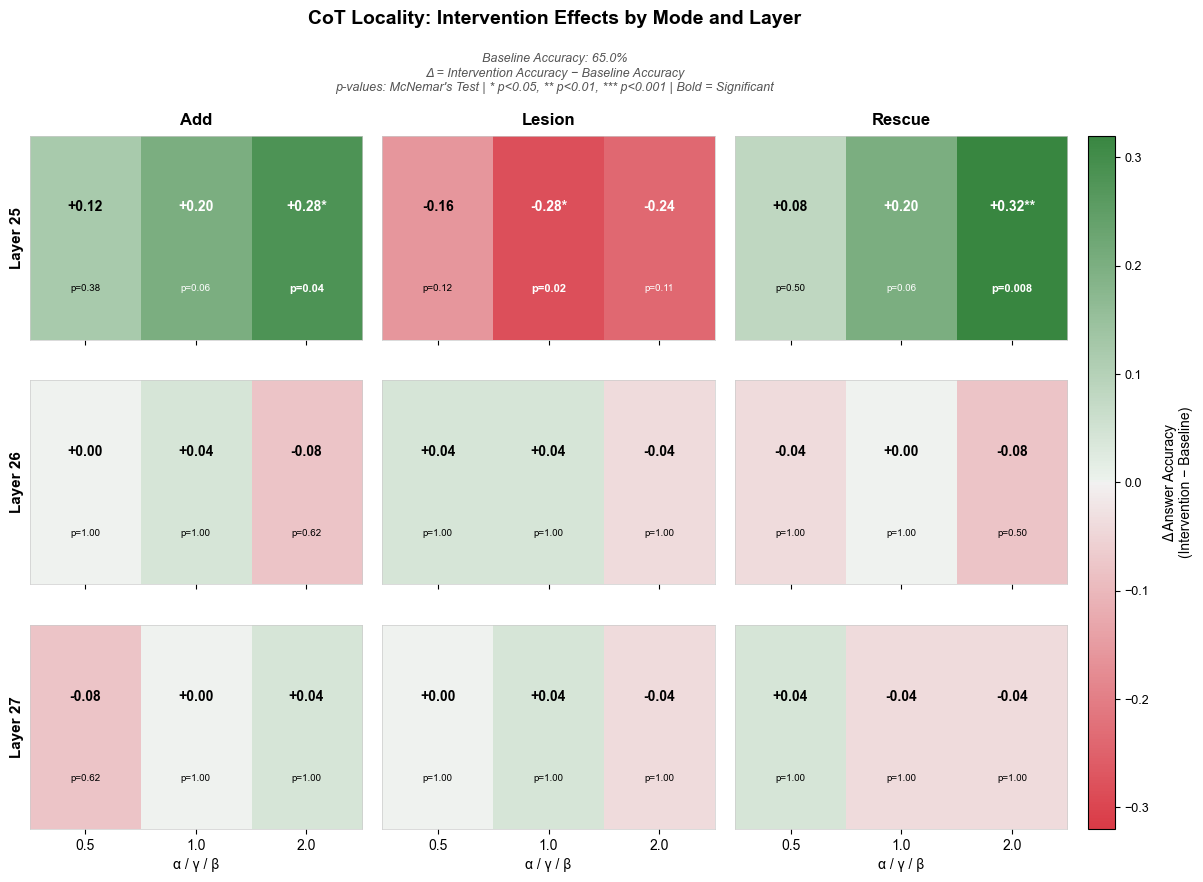

In [10]:
fig_cot = plot_mode_comparison_grid(
    stats,
    locality='cot',
    title='CoT Locality: Intervention Effects by Mode and Layer',
    save_path=OUTPUT_DIR / 'mode_comparison_cot_locality.pdf',
)
plt.show()

## 5. Answer Locality Grid

Saved to ../outputs/mode_comparison/mode_comparison_answer_locality.pdf


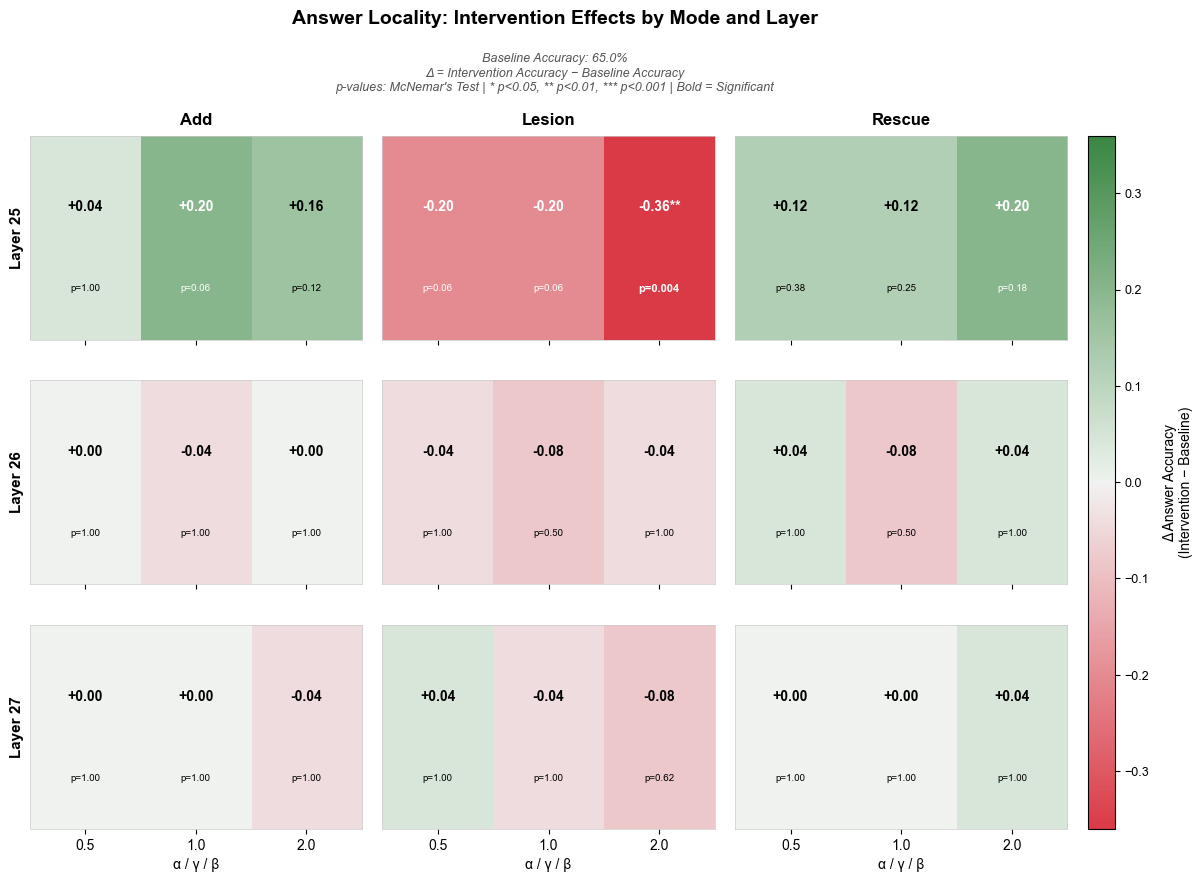

In [9]:
fig_answer = plot_mode_comparison_grid(
    stats,
    locality='answer',
    title='Answer Locality: Intervention Effects by Mode and Layer',
    save_path=OUTPUT_DIR / 'mode_comparison_answer_locality.pdf',
)
plt.show()

## 6. Side-by-Side Comparison (Layer 25)

We show bar charts for layer 25 across modes and parameter values, separately for COT and Answer localities, using the same Δ values.

**New features:**
- P-values displayed on each bar
- Significance stars and bold for significant results

Saved to ../outputs/mode_comparison/locality_comparison_layer25.pdf


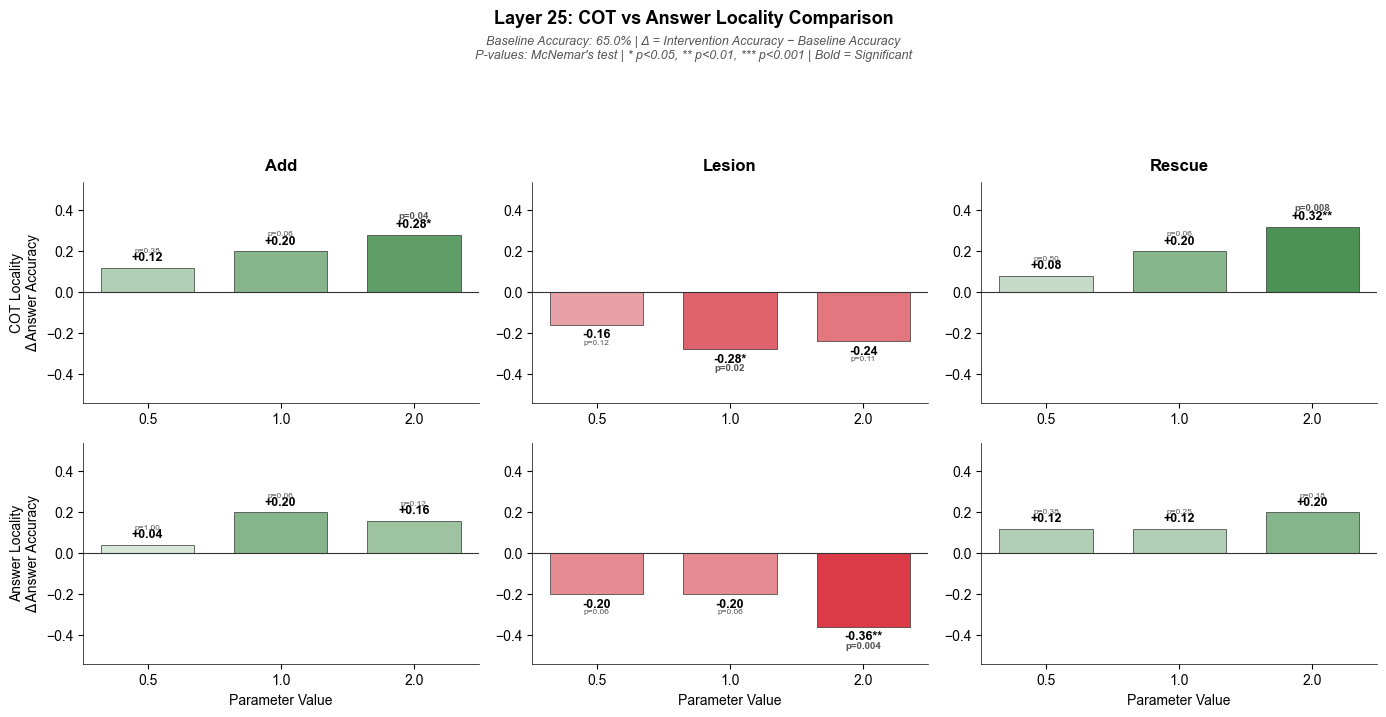

In [6]:
def plot_locality_side_by_side(stats: pd.DataFrame, save_path: Path | None = None) -> plt.Figure:
    """Create side-by-side comparison of COT and Answer locality for layer 25 with p-values.

    Uses the same Δ values from mode_comparison_stats.csv.
    P-values from McNemar's test are displayed on each bar.
    """
    fig, axes = plt.subplots(2, 3, figsize=(14, 7))

    modes = ['add', 'lesion', 'rescue']
    mode_labels = {'add': 'Add', 'lesion': 'Lesion', 'rescue': 'Rescue'}
    params_cfg = [0.5, 1.0, 2.0]
    layer = 25

    all_data = stats[(stats['layer'] == layer) & (stats['mode'].isin(modes))]
    abs_max = max(abs(all_data['delta'].min()), abs(all_data['delta'].max()))

    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    localities_cfg = [('cot', 'COT Locality'), ('answer', 'Answer Locality')]

    for row_idx, (loc_key, loc_label) in enumerate(localities_cfg):
        loc_data = all_data[all_data['locality'] == loc_key]
        for col_idx, mode in enumerate(modes):
            ax = axes[row_idx, col_idx]

            cell_data = loc_data[loc_data['mode'] == mode]
            values = []
            pvalues = []
            for p in params_cfg:
                row = cell_data[cell_data['param'] == p]
                if len(row) > 0:
                    values.append(row['delta'].values[0])
                    pvalues.append(row['mcnemar_p'].values[0] if 'mcnemar_p' in row.columns else np.nan)
                else:
                    values.append(0.0)
                    pvalues.append(np.nan)

            colors = [cmap(norm(v)) for v in values]
            bars = ax.bar(range(len(params_cfg)), values, color=colors,
                         edgecolor='#333333', linewidth=0.5, width=0.7)

            for i, (bar, val, pval) in enumerate(zip(bars, values, pvalues)):
                stars = get_significance_stars(pval)
                is_significant = pval < 0.05 if not pd.isna(pval) else False
                
                # Delta value with stars
                ypos_delta = val + 0.02 if val >= 0 else val - 0.02
                va_delta = 'bottom' if val >= 0 else 'top'
                delta_text = f'{val:+.2f}{stars}'
                fontweight = 'bold' if is_significant else 'semibold'
                ax.text(i, ypos_delta, delta_text, ha='center', va=va_delta,
                        fontsize=9, fontweight=fontweight)
                
                # P-value below/above delta
                pval_text = format_pvalue(pval)
                pval_fontweight = 'bold' if is_significant else 'normal'
                pval_fontsize = 7 if is_significant else 6
                if val >= 0:
                    ypos_pval = ypos_delta + 0.05
                    va_pval = 'bottom'
                else:
                    ypos_pval = ypos_delta - 0.05
                    va_pval = 'top'
                ax.text(i, ypos_pval, pval_text, ha='center', va=va_pval,
                        fontsize=pval_fontsize, fontweight=pval_fontweight, color='#555555')

            ax.axhline(y=0, color='#333333', linestyle='-', linewidth=0.8)
            ax.set_xticks(range(len(params_cfg)))
            ax.set_xticklabels([str(p) for p in params_cfg])
            ax.set_ylim(-abs_max * 1.5, abs_max * 1.5)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['bottom'].set_linewidth(0.5)

            if row_idx == 0:
                ax.set_title(mode_labels[mode], fontsize=12, fontweight='bold', pad=8)
            if col_idx == 0:
                ax.set_ylabel(f'{loc_label}\nΔ Answer Accuracy', fontsize=10)
            if row_idx == 1:
                ax.set_xlabel('Parameter Value', fontsize=10)

    fig.suptitle('Layer 25: COT vs Answer Locality Comparison',
                 fontsize=13, fontweight='bold', y=1.02)

    baseline_acc = 0.65
    fig.text(0.5, 0.95,
             f'Baseline Accuracy: {baseline_acc:.1%} | Δ = Intervention Accuracy − Baseline Accuracy\n'
             'P-values: McNemar\'s test | * p<0.05, ** p<0.01, *** p<0.001 | Bold = Significant',
             ha='center', fontsize=9, style='italic', color='#555555')

    plt.tight_layout(rect=[0, 0, 1, 0.88])

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")

    return fig


fig_compare = plot_locality_side_by_side(
    stats,
    save_path=OUTPUT_DIR / 'locality_comparison_layer25.pdf',
)
plt.show()

## 7. Summary

### Delta Accuracy Definition

**Δ Answer Accuracy = Intervention Accuracy − Baseline Accuracy**

- **Positive Δ**: Intervention improved performance
- **Negative Δ**: Intervention hurt performance
- **Zero Δ**: No change from intervention

### Statistical Test: McNemar's Test

**Why McNemar's test?**
- Designed specifically for **paired binary outcomes** (correct/incorrect before vs after intervention)
- Tests whether the intervention causes **asymmetric changes** (more fixes than breaks, or vice versa)
- Non-parametric: no distributional assumptions needed
- Standard in medical/behavioral research for before/after binary outcomes

**Significance thresholds:**
- `*` p < 0.05
- `**` p < 0.01  
- `***` p < 0.001
- **Bold text** indicates statistically significant results

### Interpretation Guide (by mode)

| Mode   | Expected Pattern                | Interpretation                      |
|--------|---------------------------------|-------------------------------------|
| Add    | Positive, dose-dependent       | Reasoning direction is sufficient   |
| Lesion | Negative, dose-dependent       | Reasoning direction is necessary    |
| Rescue | Positive (partial recovery)    | Causal mechanism / rescue evidence |

All patterns shown in this notebook are now grounded in the real experimental vm_results under `vm_results/results`, aggregated by `05_mode_comparison_stats.ipynb`.